Kode di bawah merupakan bagian dari proyek klasifikasi citra berbasis *machine learning* yang mencakup proses *preprocessing* citra, ekstraksi fitur, pelatihan model klasifikasi, dan evaluasi performa model. Library seperti `os`, `cv2` dari OpenCV, dan `matplotlib.pyplot` digunakan untuk membaca, memproses, serta menampilkan citra. Sementara itu, `numpy` dan `pandas` digunakan untuk manipulasi data numerik dan tabular. Library `tqdm` ditambahkan untuk menampilkan *progress bar* saat iterasi, sehingga proses dapat dipantau dengan lebih baik.

Pada tahap ekstraksi fitur, digunakan metode tekstur berbasis **GLCM (Gray Level Co-Occurrence Matrix)** dari `skimage.feature`, serta perhitungan entropi menggunakan `scipy.stats` untuk mendapatkan informasi statistik dari citra grayscale. Fitur-fitur ini kemudian menjadi input bagi model klasifikasi. Tiga algoritma utama yang digunakan dalam proses klasifikasi adalah `RandomForestClassifier` (Random Forest), `SVC` (Support Vector Machine), dan `KNeighborsClassifier` (K-Nearest Neighbors).

Evaluasi performa model dilakukan menggunakan berbagai metrik dari `sklearn.metrics`, seperti *accuracy*, *precision*, *recall*, *f1-score*, serta *confusion matrix*. Hasil evaluasi ini divisualisasikan menggunakan `ConfusionMatrixDisplay`, `matplotlib`, dan `seaborn` untuk memberikan grafik yang lebih informatif. Selain itu, `LinearSegmentedColormap` digunakan untuk membuat skema warna kustom dalam visualisasi. 


In [71]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

Fungsi di bawah membaca ukuran asli citra (lebar dan tinggi) menggunakan `img.shape[:2]`, lalu menentukan ukuran baru berdasarkan parameter `new_size`. Jika citra memiliki tiga channel (RGB), maka array kosong `resized` dibuat dalam format 3 dimensi; jika tidak, array dibuat dua dimensi untuk citra grayscale. Setelah itu, fungsi menghitung rasio skala horizontal dan vertikal antara ukuran asli dan ukuran baru menggunakan `scale_x` dan `scale_y`.Melalui dua perulangan bersarang (nested loop), fungsi menentukan posisi piksel pada citra asli yang paling mendekati posisi piksel baru, lalu menyalin nilainya. Posisi ini dihitung dengan `int(x * scale_x)` dan `int(y * scale_y)`, yang berarti piksel pada hasil resize mengambil nilai dari piksel terdekat di citra asli.

In [72]:
def resize_image(img, new_size=(256, 256)):
    original_height, original_width = img.shape[:2]
    new_width, new_height = new_size

    if len(img.shape) == 3:
        resized = np.zeros((new_height, new_width, img.shape[2]), dtype=img.dtype)
    else:
        resized = np.zeros((new_height, new_width), dtype=img.dtype)

    scale_x = original_width / new_width
    scale_y = original_height / new_height

    for y in range(new_height):
        for x in range(new_width):
            orig_x = int(x * scale_x)
            orig_y = int(y * scale_y)
            resized[y, x] = img[orig_y, orig_x]

    return resized

Fungsi `insertGambar(folder)` bertujuan untuk membaca gambar dari struktur folder yang berisi subfolder berdasarkan label kelas, lalu menyimpannya ke dalam bentuk array citra yang telah diproses (resized). Fungsi ini sekaligus mencatat nama file, label gambar, dan jumlah distribusi data per kelas. Pertama, fungsi akan membuat beberapa list kosong yaitu `data` (untuk menyimpan citra), `filenames` (nama file), `datalabel` (label unik), dan `path` (label tiap gambar), serta dictionary `data_distribution` untuk menghitung jumlah gambar di setiap label. Kemudian, dilakukan iterasi terhadap setiap subfolder (label kelas) di dalam `folder`, dan nama subfolder dianggap sebagai label. Setiap gambar dibaca menggunakan `cv.imread`, kemudian dikonversi dari format BGR (default OpenCV) ke RGB menggunakan `cv.cvtColor`, dan diubah ukurannya menjadi 256x256 piksel menggunakan fungsi `resize_image`. Gambar yang valid (tidak `None`) akan dimasukkan ke dalam list `data`, sementara nama file dan label kelasnya dimasukkan ke list `filenames` dan `path`. Sebagai hasil akhirnya, fungsi ini mengembalikan lima elemen penting: list gambar (`data`), list nama file (`filenames`), list label unik (`datalabel`), list label per gambar (`path`), dan distribusi data per kelas (`data_distribution`). 

In [73]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in os.listdir(folder):
        images = os.listdir(folder + label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        for filename in tqdm(images):
            img = cv.imread(os.path.join(folder + label, filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (256, 256))
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path, data_distribution

Setelah fungsi `insertGambar("Dataset2/")` dipanggil, lima komponen penting dikembalikan, yaitu `citras`, `filenames`, `labels`, `path`, dan `distribusi`. Variabel `citras` menyimpan kumpulan citra yang telah dibaca dan diubah ukurannya menjadi 256x256 piksel. `filenames` berisi nama-nama file gambar, sementara `labels` menyimpan daftar label unik yang merepresentasikan kelas atau kategori gambar berdasarkan nama folder. Variabel `path` berisi label untuk setiap gambar, mencerminkan dari folder mana gambar tersebut berasal. Terakhir, `distribusi` merupakan sebuah dictionary yang menunjukkan jumlah gambar untuk masing-masing kelas, membantu dalam melihat sebaran data. Setelah data dimuat, kode mencetak beberapa informasi penting untuk keperluan validasi dataset, yaitu jumlah total gambar yang berhasil dibaca (`len(citras)`), jumlah label unik (`len(labels)`), jumlah nama file (`len(filenames)`), serta distribusi data per kelas yang diambil dari `distribusi`. Tahap ini penting dilakukan sebelum lanjut ke proses preprocessing, ekstraksi fitur, atau pelatihan model, untuk memastikan bahwa data telah terbaca dengan baik dan proporsional antar kelas.

In [74]:
images, filenames, labels, path, distribusi = insertGambar("Dataset2/")

print("Jumlah gambar:", len(images))
print("Jumlah label unik:", len(labels))
print("Jumlah nama file:", len(filenames))
print("Distribusi data:", distribusi)


basophil


100%|██████████| 100/100 [00:02<00:00, 36.06it/s]


seg_neutrophil


100%|██████████| 100/100 [00:03<00:00, 31.85it/s]


Jumlah gambar: 200
Jumlah label unik: 2
Jumlah nama file: 200
Distribusi data: {'basophil': 100, 'seg_neutrophil': 100}


Fungsi `gray_scaling(img)` mengubah citra berwarna (RGB) menjadi citra grayscale menggunakan konversi warna dari BGR ke skala abu-abu dengan OpenCV (`cv.COLOR_BGR2GRAY`). Ini merupakan langkah awal umum dalam pemrosesan citra karena banyak algoritma analisis hanya membutuhkan informasi intensitas.

Fungsi `median_filtering(img)` melakukan median filter 3x3 untuk mengurangi noise (khususnya noise salt-and-pepper) pada citra grayscale. Proses ini dilakukan dengan menambahkan padding pada citra, kemudian setiap piksel diganti dengan nilai median dari jendela 3x3 di sekitarnya.

Fungsi `sobel(image)` menghitung deteksi tepi pada citra dengan menerapkan filter Sobel untuk arah horizontal (`sobel_x`) dan vertikal (`sobel_y`). Gradien pada setiap arah dihitung, lalu digunakan magnitudo gradien total (`sqrt(gx² + gy²)`) sebagai hasil akhir, kemudian dinormalisasi ke skala 0-255.

Fungsi `erosi(citra, kernel)` menerapkan operasi erosi morfologi, yaitu menggantikan setiap piksel dengan nilai minimum dalam area yang ditentukan kernel. Fungsi ini berguna untuk menghilangkan noise kecil atau menyusutkan objek terang dalam citra.

Sebaliknya, `dilasi(citra, kernel)` menerapkan dilasi, yaitu menggantikan setiap piksel dengan nilai maksimum dalam area kernel. Dilasi berguna untuk memperbesar area terang atau menutup lubang kecil pada objek.

Fungsi `opening(citra)` merupakan gabungan dari erosi yang diikuti oleh dilasi. Tujuan operasi ini adalah untuk menghilangkan noise kecil pada citra sambil mempertahankan bentuk objek utama.

Fungsi `manual_clahe(gray_img, clip_limit, tile_grid_size)` adalah implementasi manual dari CLAHE (Contrast Limited Adaptive Histogram Equalization). Fungsi ini meningkatkan kontras lokal citra grayscale dengan cara membagi citra menjadi tile (ubin) kecil, melakukan equalization histogram dengan pembatasan clip limit untuk menghindari amplifikasi noise, kemudian menerapkan interpolasi bilinear antar tile agar transisi antar bagian citra tetap halus.

Terakhir, fungsi `normalize(image, skala_min, skala_max)` digunakan untuk menyesuaikan nilai piksel dari citra ke dalam rentang skala tertentu, biasanya 0-255. Ini penting untuk memastikan bahwa hasil akhir citra memiliki tingkat intensitas yang konsisten dan sesuai untuk ditampilkan atau diproses lebih lanjut.

Dengan gabungan fungsi-fungsi ini, pipeline preprocessing menjadi lengkap, mencakup peningkatan kualitas citra, pengurangan noise, peningkatan kontras, dan persiapan untuk ekstraksi fitur atau klasifikasi.


In [75]:
def gray_scaling(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return gray

def median_filtering(img):
    pad = 1
    padded_img = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            window = padded_img[i:i+3, j:j+3].flatten()
            result[i, j] = np.median(window)
    return result

def sobel(image):
    sobel_x = np.array([[1, 0, -1], 
                        [2, 0, -2], 
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    padded_img = np.pad(image, pad_width=1, mode='constant', constant_values=0)
    sobel_result = np.zeros_like(image, dtype=np.uint8)
    
    for i in range(1, padded_img.shape[0] - 1):
        for j in range(1, padded_img.shape[1] - 1):
            region = padded_img[i-1:i+2, j-1:j+2]

            gx = np.sum(region * sobel_x)
            gy = np.sum(region * sobel_y)

            sobel_result[i-1, j-1] = np.sqrt(gx**2 + gy**2)
    sobel_result = (sobel_result / np.max(sobel_result) * 255).astype(np.uint8)
    
    return sobel_result

def erosi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilasi(citra, kernel):
    pad = kernel.shape[0] // 2
    padded = np.pad(citra, pad, mode='constant')
    result = np.zeros_like(citra)
    for i in range(citra.shape[0]):
        for j in range(citra.shape[1]):
            region = padded[i:i+kernel.shape[0], j:j+kernel.shape[1]]
            result[i, j] = np.max(region[kernel == 1])
    return result

def opening(citra):
    kernel = np.ones((3, 3), dtype=np.uint8)
    citra_erosi = erosi(citra, kernel)
    citra_opening = dilasi(citra_erosi, kernel)
    return citra_opening

def manual_clahe(gray_img: np.ndarray, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    h, w = gray_img.shape
    n_tiles_x, n_tiles_y = tile_grid_size
    tile_h = h // n_tiles_y
    tile_w = w // n_tiles_x
    bins = 256
    
    # Hitung clip limit aktual dalam jumlah pixel
    tile_size = tile_h * tile_w
    clip_limit_pixel = int((clip_limit * tile_size) / bins)
    
    # Buat hasil yang akan diisi
    result = np.zeros_like(gray_img, dtype=np.uint8)
    
    # Simpan semua mapping untuk setiap tile
    maps = np.zeros((n_tiles_y, n_tiles_x, bins), dtype=np.uint8)

    # Hitung histogram & mapping untuk tiap tile
    for i in range(n_tiles_y):
        for j in range(n_tiles_x):
            y0, y1 = i * tile_h, (i + 1) * tile_h
            x0, x1 = j * tile_w, (j + 1) * tile_w
            tile = gray_img[y0:y1, x0:x1]
            
            hist, _ = np.histogram(tile, bins=bins, range=(0, 256))
            
            # Clipping
            excess = np.maximum(hist - clip_limit_pixel, 0)
            clipped_hist = hist.copy()
            clipped_hist[clipped_hist > clip_limit_pixel] = clip_limit_pixel
            redistribute = np.sum(excess) // bins
            clipped_hist += redistribute
            
            # Hitung CDF
            cdf = np.cumsum(clipped_hist)
            cdf_min = cdf.min()
            cdf_range = cdf.max() - cdf_min
            if cdf_range == 0:
                cdf_range = 1
            mapping = ((cdf - cdf_min) * 255 / cdf_range).astype(np.uint8)
            maps[i, j] = mapping
    
    # Interpolasi antar tile
    for i in range(h):
        for j in range(w):
            # Posisi relatif di grid tile
            y_frac = (i + 0.5) / tile_h - 0.5
            x_frac = (j + 0.5) / tile_w - 0.5

            y = int(np.floor(y_frac))
            x = int(np.floor(x_frac))

            y = max(0, min(y, n_tiles_y - 2))
            x = max(0, min(x, n_tiles_x - 2))

            dy = y_frac - y
            dx = x_frac - x

            val = gray_img[i, j]

            # Ambil 4 tetangga mapping
            m00 = maps[y, x, val]
            m01 = maps[y, x + 1, val]
            m10 = maps[y + 1, x, val]
            m11 = maps[y + 1, x + 1, val]

            # Bilinear interpolation
            top = (1 - dx) * m00 + dx * m01
            bottom = (1 - dx) * m10 + dx * m11
            interpolated_val = (1 - dy) * top + dy * bottom
            result[i, j] = np.clip(int(round(interpolated_val)), 0, 255)


    return result

def normalize(image, skala_min=0, skala_max=255):
    image = image.astype(np.float32)
    min_val, max_val = np.min(image), np.max(image)

    if max_val == min_val:
        return np.full(image.shape, skala_min, dtype=np.uint8)  

    return ((image - min_val) * (skala_max - skala_min) / (max_val - min_val) + skala_min).astype(np.uint8)

Pertama-tama, citra `images[1]` diubah ukurannya menggunakan fungsi `resize_image` dan hasilnya disimpan dalam `resize_img`. Selanjutnya, gambar hasil resize dikonversi ke grayscale melalui fungsi `gray_scaling`, sehingga informasi warna diubah menjadi skala intensitas abu-abu untuk mempermudah analisis lanjutan. Setelah itu, citra grayscale ditingkatkan kontrasnya secara lokal menggunakan metode CLAHE (Contrast Limited Adaptive Histogram Equalization) dengan clip limit `5` dan pembagian tile `(4, 4)`. Proses ini menghasilkan `citra_clahe`, yang merupakan versi citra dengan kontras yang lebih tajam dan merata di berbagai bagian gambar.

Kemudian, untuk mengurangi noise yang masih tersisa, `citra_clahe` diproses menggunakan median filtering, yang menghasilkan `medianData`. Filter ini sangat efektif untuk menghilangkan noise tanpa mengaburkan tepi objek. Setelah noise dikurangi, dilakukan deteksi tepi menggunakan operator Sobel pada hasil median filter, menghasilkan `citra_sobel` yang menonjolkan kontur atau tepi objek dalam citra. Tahap terakhir adalah normalisasi hasil deteksi tepi dengan fungsi `normalize`, untuk memastikan nilai piksel berada dalam rentang 0–255 agar dapat ditampilkan dan diproses lebih lanjut. Hasil akhirnya (`normalizeData`) divisualisasikan menggunakan `plt.imshow` dengan colormap abu-abu (`cmap='gray'`), menampilkan citra akhir setelah seluruh rangkaian preprocessing selesai.

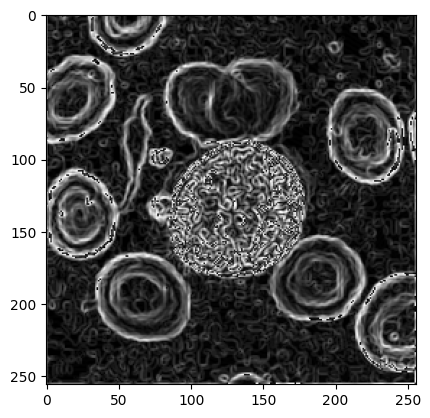

In [76]:
resize_img = resize_image(images[1])  
gray_img = gray_scaling(resize_img)  

citra_clahe = manual_clahe(gray_img, 5, (4,4))

medianData = median_filtering(citra_clahe)  
citra_sobel = sobel(medianData)  

normalizeData = normalize(citra_sobel)  

plt.imshow(normalizeData, cmap="gray")


Kode di bawah digunakan untuk melakukan preprocessing pada seluruh citra dalam daftar `images`. Setiap citra diproses melalui beberapa tahapan: pertama di-*resize*, kemudian dikonversi ke grayscale, ditingkatkan kontrasnya menggunakan metode CLAHE, dikurangi *noise*-nya dengan median filtering, dilanjutkan dengan deteksi tepi menggunakan operator Sobel, lalu hasil akhirnya dinormalisasi ke rentang intensitas 0–255. Semua hasil preprocessing disimpan ke dalam list `dataPreprocessed`.


In [77]:
dataPreprocessed = []
for i in range(len(images)):  
    resize_img = resize_image(images[i])  
    gray_img = gray_scaling(resize_img)  
    
    citra_clahe = manual_clahe(gray_img, 5, (4, 4))
    
    medianData = median_filtering(citra_clahe)  
    citra_sobel = sobel(medianData)  
    
    normalizeData = normalize(citra_sobel)  

    dataPreprocessed.append(normalizeData)

Kode di bawah digunakan untuk menampilkan hasil preprocessing dari maksimal 200 citra dalam grid. Citra-citra tersebut diambil dari list `dataPreprocessed`, di-*resize* kembali jika diperlukan, lalu ditampilkan dalam skema warna grayscale menggunakan `matplotlib`. Grid disusun dalam 20 kolom, dan jumlah baris disesuaikan secara otomatis. Setiap subplot diberi *axis off* agar tampilan lebih bersih, dan `tight_layout()` digunakan agar jarak antar gambar rapat tanpa tumpang tindih.


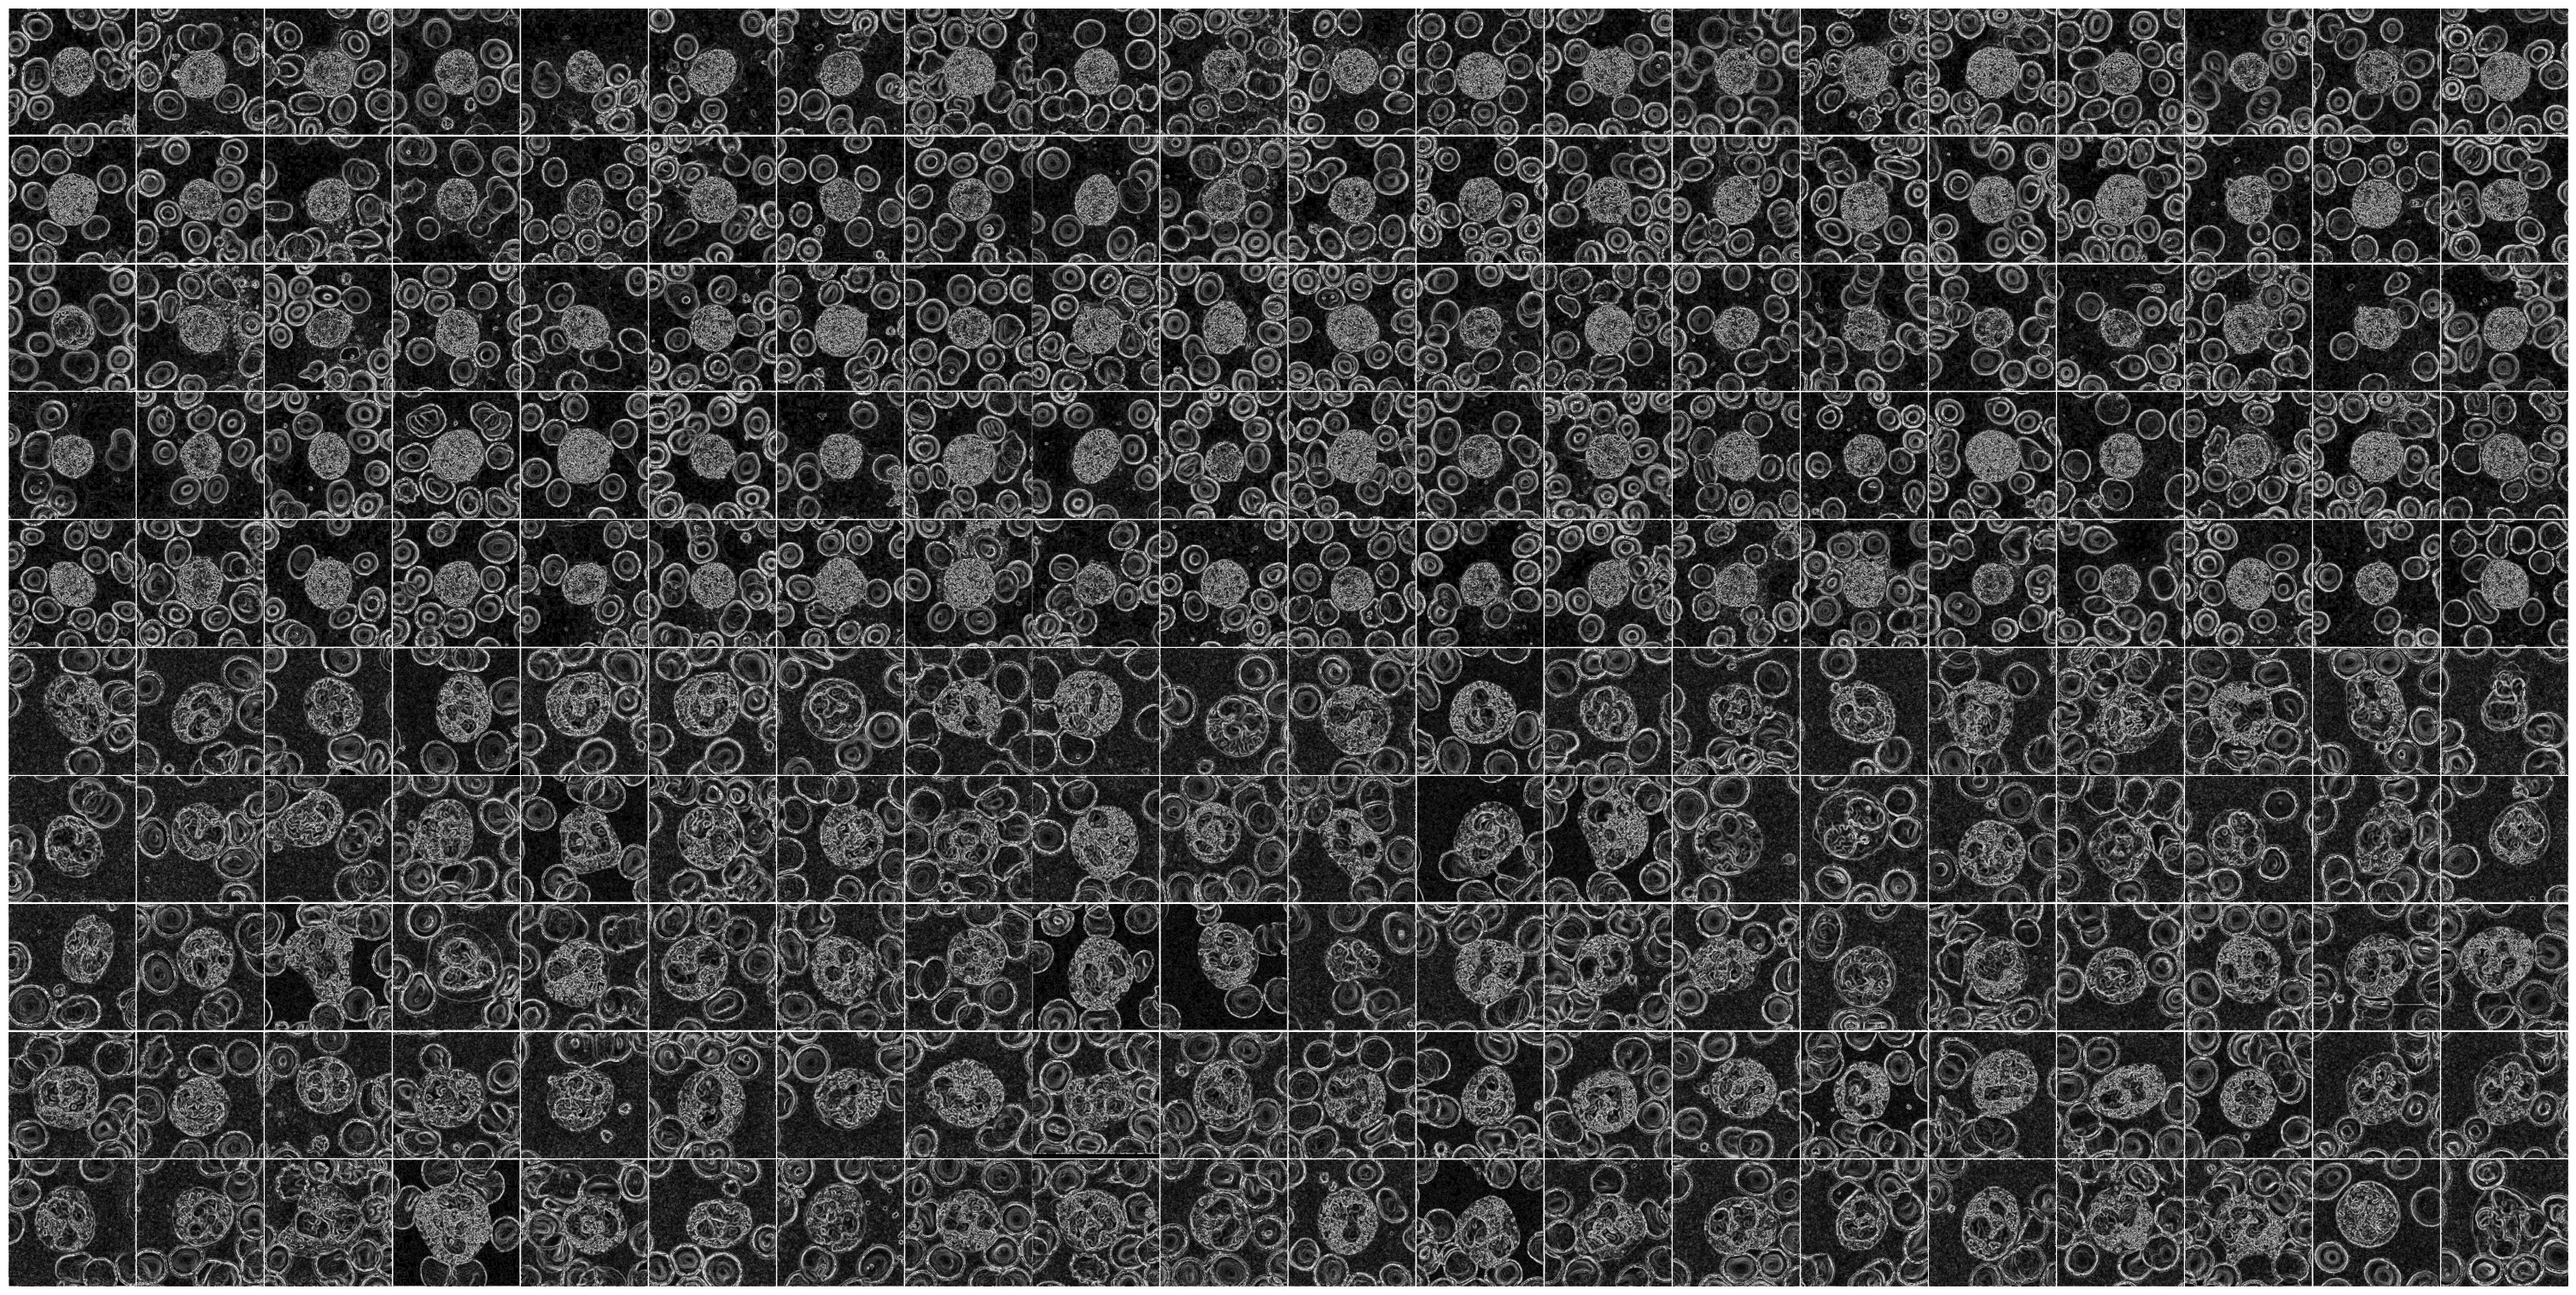

In [78]:
num_images = min(len(images), 200)  

cols = 20  
rows = (num_images // cols) + (1 if num_images % cols else 0)  

fig, axes = plt.subplots(rows, cols, figsize=(30, 15))

for i, ax in enumerate(axes.flat):
    
    if i < num_images:
        img = resize_image(dataPreprocessed[i])  
        ax.imshow(img, cmap='gray')
        ax.axis("off")
    else:
        ax.axis("off")  

plt.tight_layout(pad=0.1)  
plt.show()

<h1>Feature Extraction</h1>

Fungsi `glcm` menerima dua parameter: citra grayscale `image` dan sudut arah `derajat` dalam satuan derajat yang hanya bisa bernilai 0, 45, 90, atau 135. Berdasarkan nilai `derajat`, fungsi akan mengkonversi sudut tersebut ke dalam radian yang dibutuhkan oleh fungsi `graycomatrix` dari `skimage.feature`. Fungsi `graycomatrix` kemudian digunakan untuk menghitung matriks ko-ocurrence tingkat abu-abu dengan jarak piksel 1 pada arah yang ditentukan, serta menghasilkan matriks yang simetris dan ternormalisasi. Matriks GLCM yang dihasilkan ini dapat digunakan untuk analisis tekstur lebih lanjut seperti menghitung fitur kontras, homogenitas, energi, dan entropi.

In [79]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi `correlation` digunakan untuk menghitung fitur korelasi dari matriks Gray Level Co-occurrence Matrix (GLCM). Korelasi merupakan salah satu fitur tekstur yang mengukur sejauh mana piksel-piksel dalam citra memiliki hubungan linear atau keterkaitan spasial pada jarak dan arah tertentu. Fungsi ini menerima sebuah matriks GLCM sebagai input dan memanfaatkan fungsi `graycoprops` dari pustaka `skimage.feature` untuk mengambil nilai korelasi. Nilai yang dikembalikan adalah sebuah skalar yang menggambarkan tingkat korelasi antar piksel dalam citra berdasarkan GLCM tersebut. Fitur korelasi ini penting dalam analisis tekstur karena memberikan informasi tentang pola hubungan piksel yang dapat digunakan untuk klasifikasi citra.

In [80]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi `dissimilarity` digunakan untuk menghitung fitur dissimilarity dari matriks Gray Level Co-occurrence Matrix (GLCM). Dissimilarity adalah ukuran tekstur yang menunjukkan perbedaan atau variasi intensitas antara pasangan piksel yang berdekatan dalam citra. Nilai dissimilarity yang lebih tinggi menunjukkan perbedaan yang lebih besar antar piksel, sehingga menggambarkan tekstur yang lebih kasar atau tidak seragam. Fungsi ini menerima matriks GLCM sebagai input dan menggunakan fungsi `graycoprops` dari pustaka `skimage.feature` untuk mengambil nilai dissimilarity. Hasil yang dikembalikan berupa sebuah skalar yang mewakili tingkat ketidaksamaan intensitas piksel dalam citra berdasarkan GLCM tersebut. Fitur ini berguna dalam analisis tekstur dan klasifikasi citra untuk membedakan pola permukaan yang berbeda.


In [81]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi `homogeneity` digunakan untuk menghitung fitur homogenitas dari matriks Gray Level Co-occurrence Matrix (GLCM). Homogenitas mengukur keseragaman tekstur dalam citra dengan memperhatikan kedekatan nilai intensitas piksel yang berpasangan. Nilai homogenitas yang tinggi menunjukkan bahwa piksel-piksel yang berdekatan memiliki intensitas yang serupa, sehingga tekstur citra terlihat lebih halus dan seragam. Fungsi ini menerima matriks GLCM sebagai input dan memanfaatkan fungsi `graycoprops` dari pustaka `skimage.feature` untuk mengambil nilai homogenitas. Nilai yang dikembalikan berupa skalar yang mencerminkan tingkat keseragaman tekstur dalam citra tersebut. Fitur homogenitas ini sangat berguna dalam analisis citra untuk membedakan pola tekstur yang halus dari yang kasar.


In [82]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi `contrast` digunakan untuk menghitung fitur kontras dari matriks Gray Level Co-occurrence Matrix (GLCM). Kontras mengukur variasi intensitas antara piksel-piksel yang berdekatan dalam citra, yang mencerminkan tingkat perbedaan tekstur. Nilai kontras yang tinggi menunjukkan adanya perubahan intensitas yang signifikan dan tekstur yang lebih kasar, sedangkan nilai kontras rendah menunjukkan tekstur yang lebih halus dan homogen. Fungsi ini menerima matriks GLCM sebagai input dan menggunakan fungsi `graycoprops` dari pustaka `skimage.feature` untuk mendapatkan nilai kontras. Nilai yang dikembalikan berupa skalar yang menggambarkan tingkat variasi tekstur pada citra, yang sangat berguna dalam klasifikasi dan analisis citra berbasis tekstur.

In [83]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi `ASM` (Angular Second Moment) digunakan untuk menghitung salah satu fitur tekstur dari matriks Gray Level Co-occurrence Matrix (GLCM). ASM mengukur tingkat homogenitas atau keteraturan tekstur dalam citra, dengan nilai yang lebih tinggi menunjukkan tekstur yang lebih seragam dan konsisten. Fitur ini sangat berguna untuk membedakan antara area citra dengan pola tekstur yang halus dan kasar. Fungsi ini menerima matriks GLCM sebagai input dan menggunakan fungsi `graycoprops` dari pustaka `skimage.feature` untuk menghitung nilai ASM. Nilai yang dikembalikan adalah sebuah skalar yang menunjukkan tingkat keteraturan tekstur pada citra, yang dapat digunakan sebagai parameter dalam analisis dan klasifikasi citra berbasis tekstur.

In [84]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi `energy` digunakan untuk menghitung fitur tekstur dari matriks Gray Level Co-occurrence Matrix (GLCM) yang disebut energi. Energi mengukur keseragaman atau kekompakan distribusi tekstur dalam citra, dengan nilai yang lebih tinggi menunjukkan pola tekstur yang lebih teratur dan kurang berisik. Fitur ini sering digunakan untuk menganalisis karakteristik tekstur dalam pemrosesan citra dan klasifikasi. Fungsi ini menerima matriks GLCM sebagai input dan memanfaatkan fungsi `graycoprops` dari pustaka `skimage.feature` untuk memperoleh nilai energi. Hasilnya berupa angka tunggal yang merepresentasikan tingkat kekompakan tekstur, yang dapat digunakan untuk membedakan berbagai jenis pola tekstur dalam citra.

In [85]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi `entropyGlcm` digunakan untuk menghitung nilai entropi dari matriks Gray Level Co-occurrence Matrix (GLCM). Entropi adalah ukuran ketidakteraturan atau kompleksitas dalam distribusi tekstur citra; semakin tinggi nilai entropi, semakin acak atau kompleks tekstur tersebut. Fungsi ini mengambil matriks GLCM sebagai input, kemudian menggunakan fungsi `entropy` dari pustaka `scipy.stats` untuk menghitung entropi berdasarkan distribusi probabilitas nilai-nilai dalam matriks tersebut. Matriks GLCM diubah menjadi vektor satu dimensi menggunakan metode `.ravel()` agar sesuai dengan format input fungsi `entropy`. Nilai entropi yang dihasilkan dapat digunakan sebagai fitur tekstur penting dalam analisis dan klasifikasi citra.

In [86]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode di bawah melakukan perhitungan Gray Level Co-occurrence Matrix (GLCM) pada setiap citra dalam daftar `images` untuk empat sudut atau derajat arah yang berbeda, yaitu 0°, 45°, 90°, dan 135°. Pada setiap iterasi, fungsi `glcm` dipanggil dengan citra dan sudut tertentu sebagai parameter, menghasilkan matriks GLCM untuk arah tersebut. Matriks-matriks hasil ini kemudian disimpan ke dalam empat list terpisah: `Derajat0`, `Derajat45`, `Derajat90`, dan `Derajat135`. Tujuan dari langkah ini adalah untuk mendapatkan representasi tekstur citra dari berbagai arah agar fitur tekstur yang dihasilkan lebih lengkap dan representatif untuk proses klasifikasi atau analisis citra selanjutnya.


In [87]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode di bawah menginisialisasi beberapa list kosong yang akan digunakan untuk menyimpan nilai fitur tekstur hasil ekstraksi dari matriks GLCM pada berbagai arah sudut, yaitu 0°, 45°, 90°, dan 135°. Fitur-fitur tersebut meliputi kontras (contrast), dissimilarity, homogenitas (homogeneity), entropi (entropy), Angular Second Moment (ASM), energi (energy), dan korelasi (correlation). Setiap fitur memiliki empat list terpisah yang merepresentasikan nilai-nilai fitur dari citra pada masing-masing arah sudut tersebut. Pendekatan ini bertujuan untuk mengorganisir data fitur secara rapi dan memudahkan analisis atau klasifikasi berdasarkan perbedaan karakteristik tekstur di setiap arah.

In [88]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode di bawah melakukan iterasi pada seluruh citra yang telah diproses, kemudian untuk setiap citra menghitung nilai homogenitas (homogeneity) dari matriks GLCM yang sudah diekstraksi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Hasil perhitungan homogenitas untuk setiap sudut kemudian disimpan secara terpisah dalam list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Pendekatan ini memungkinkan analisis fitur homogenitas berdasarkan arah tekstur pada citra, yang bisa menjadi informasi penting untuk klasifikasi atau pengenalan pola.


In [89]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    homogenity0.append(H0)
    H45 = homogenity(Derajat45[i])
    homogenity45.append(H45)
    H90 = homogenity(Derajat90[i])
    homogenity90.append(H90)
    H135 = homogenity(Derajat135[i])
    homogenity135.append(H135)

Kode di bawah melakukan perulangan pada seluruh citra yang telah diproses, kemudian untuk setiap citra menghitung nilai korelasi (correlation) dari matriks GLCM yang telah diekstraksi pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Nilai korelasi yang didapat untuk tiap sudut disimpan secara terpisah dalam list `correlation0`, `correlation45`, `correlation90`, dan `correlation135`. Nilai korelasi ini merepresentasikan hubungan linier antara intensitas piksel yang berdekatan dalam arah tertentu, sehingga dapat digunakan untuk menganalisis pola tekstur pada citra.

In [90]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Kode di bawah melakukan iterasi pada seluruh citra yang telah diproses, kemudian menghitung nilai kontras (contrast) dari matriks GLCM untuk setiap citra pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Nilai kontras yang diperoleh dari tiap sudut tersebut kemudian disimpan dalam list yang sesuai, yaitu `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`. Kontras merupakan salah satu fitur tekstur yang mengukur variasi intensitas piksel di dalam citra, di mana nilai yang lebih tinggi menunjukkan perubahan intensitas yang lebih besar dan tekstur yang lebih kasar.


In [91]:
for i in range(len(images)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Kode di bawah melakukan perulangan pada setiap citra yang telah diproses untuk menghitung nilai fitur tekstur dissimilarity dari matriks GLCM pada empat sudut yang berbeda: 0°, 45°, 90°, dan 135°. Nilai dissimilarity yang diperoleh dari setiap sudut tersebut kemudian dimasukkan ke dalam list yang sesuai, yaitu `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`. Fitur dissimilarity ini mengukur tingkat perbedaan intensitas piksel tetangga dalam citra, di mana nilai yang lebih tinggi menunjukkan variasi tekstur yang lebih besar dan ketidaksamaan piksel yang lebih signifikan.

In [92]:
for i in range(len(images)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Kode di bawah melakukan iterasi pada setiap citra yang telah diproses untuk menghitung nilai entropi dari matriks GLCM pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Entropi GLCM dihitung dengan memanggil fungsi `entropyGlcm`, yang mengukur tingkat kompleksitas atau ketidakteraturan tekstur pada citra. Nilai entropi yang dihasilkan kemudian disimpan ke dalam list terpisah sesuai sudutnya: `entropy0`, `entropy45`, `entropy90`, dan `entropy135`. Entropi yang lebih tinggi mengindikasikan tekstur yang lebih acak atau kompleks.

In [93]:
for i in range(len(images)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Kode di bawah melakukan perulangan pada setiap citra untuk menghitung nilai ASM (Angular Second Moment) dari matriks GLCM pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. Fungsi `ASM` mengambil matriks GLCM sebagai input dan mengembalikan nilai ASM yang mengukur tingkat keseragaman atau homogenitas tekstur pada citra. Nilai ASM yang diperoleh kemudian disimpan dalam daftar terpisah sesuai sudutnya, yaitu `ASM0`, `ASM45`, `ASM90`, dan `ASM135`. Nilai ASM yang lebih tinggi menunjukkan tekstur yang lebih seragam dan teratur.


In [94]:
for i in range(len(images)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Kode di bawah melakukan iterasi pada setiap citra untuk menghitung nilai energy dari matriks GLCM pada empat sudut yang berbeda: 0°, 45°, 90°, dan 135°. Fungsi `energy` menerima matriks GLCM sebagai input dan mengembalikan nilai energy yang mengukur intensitas dan kekuatan tekstur citra. Nilai energy tersebut kemudian disimpan ke dalam list yang sesuai berdasarkan sudutnya, yaitu `energy0`, `energy45`, `energy90`, dan `energy135`. Energy yang lebih tinggi menunjukkan tekstur yang lebih halus dan teratur pada citra.

In [95]:
for i in range(len(images)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode di bawah mencetak jumlah elemen pada berbagai list yang telah dibuat dan dihitung sebelumnya. Pertama, jumlah label yang tersimpan dalam list `path` dan jumlah nama file dalam list `filenames` ditampilkan. Selanjutnya, kode ini menampilkan panjang dari setiap list fitur tekstur GLCM yang dihitung pada empat arah (0°, 45°, 90°, 135°) untuk berbagai fitur seperti kontras, homogeneity, dissimilarity, entropy, ASM, energy, dan korelasi. Tujuan dari pencetakan ini adalah untuk memastikan bahwa setiap list fitur memiliki jumlah elemen yang konsisten dan sesuai dengan jumlah citra atau data yang diolah, sehingga validitas dan kesesuaian data dapat diverifikasi sebelum digunakan lebih lanjut dalam analisis atau pemodelan.

In [96]:
print("Jumlah Labels:", len(path))
print("Jumlah Filename:", len(filenames))
print("Jumlah Kontras0:", len(Kontras0), len(Kontras45), len(Kontras90), len(Kontras135))
print("Jumlah Homogeneity0:", len(homogenity0), len(homogenity45), len(homogenity90), len(homogenity135))
print("Jumlah Dissimilarity0:", len(dissimilarity0), len(dissimilarity45), len(dissimilarity90), len(dissimilarity135))
print("Jumlah Entropy0:", len(entropy0), len(entropy45), len(entropy90), len(entropy135))
print("Jumlah ASM0:", len(ASM0), len(ASM45), len(ASM90), len(ASM135))
print("Jumlah Energy0:", len(energy0), len(energy45), len(energy90), len(energy135))
print("Jumlah Correlation0:", len(correlation0), len(correlation45), len(correlation90), len(correlation135))

Jumlah Labels: 200
Jumlah Filename: 200
Jumlah Kontras0: 200 200 200 200
Jumlah Homogeneity0: 200 200 200 200
Jumlah Dissimilarity0: 200 200 200 200
Jumlah Entropy0: 200 200 200 200
Jumlah ASM0: 200 200 200 200
Jumlah Energy0: 200 200 200 200
Jumlah Correlation0: 200 200 200 200


<h1>CSV</h1>

Kode di bawah membuat sebuah DataFrame menggunakan pustaka pandas dengan menggabungkan berbagai fitur tekstur hasil ekstraksi dari citra serta metadata seperti nama file dan label. Setiap kolom pada DataFrame mewakili fitur yang dihitung pada empat arah sudut (0°, 45°, 90°, 135°) seperti kontras, homogenitas, dissimilarity, entropi, ASM, energi, dan korelasi, selain juga kolom untuk nama file dan label kategori citra. Setelah DataFrame terbentuk, data tersebut disimpan ke dalam sebuah file CSV bernama `hasil_ekstraksi_tanpa_prepro.csv` tanpa menyertakan indeks baris. Kemudian, file CSV tersebut dibaca kembali ke dalam variabel `hasilEkstrak` dan ditampilkan, sehingga memungkinkan pengecekan data hasil ekstraksi yang sudah tersimpan.

In [97]:
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_2.csv')
hasilEkstrak

Filename           Label    Contrast0   Contrast45   Contrast90  \
0    BA_129641.jpg        basophil  1605.811366  2204.670988  1609.620833   
1    BA_139552.jpg        basophil  1641.820650  2277.623714  1674.306541   
2    BA_141630.jpg        basophil  1892.008425  2660.609366  2032.146814   
3    BA_145728.jpg        basophil  1012.601716  1479.690442  1028.781924   
4    BA_152650.jpg        basophil  1240.146262  1634.759293  1191.308012   
..             ...             ...          ...          ...          ...   
195   NGS_4167.jpg  seg_neutrophil  1966.337316  2420.882153  1891.178906   
196   NGS_4306.jpg  seg_neutrophil  2274.232108  2864.837785  2367.152053   
197   NGS_4433.jpg  seg_neutrophil  2487.832935  3127.448658  2567.208517   
198   NGS_4499.jpg  seg_neutrophil  1270.125858  1823.161845  1353.463358   
199   NGS_4559.jpg  seg_neutrophil  1751.898652  2355.376624  1765.996109   

     Contrast135  Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  \
0    2220.766628      0.143431       0.103807       0.144224        0.108287   
1    2187.663422      0.106418       0.075901       0.100973        0.070495   
2    2654.829189      0.109419       0.077301       0.106802        0.080003   
3    1469.906467      0.126496       0.090585       0.126064        0.095274   
4    1626.957693      0.221374       0.148881       0.186021        0.151388   
..           ...           ...            ...            ...             ...   
195  2358.557555      0.067751       0.053910       0.070686        0.052668   
196  2949.114402      0.059995       0.047130       0.061586        0.047598   
197  3160.847105      0.061716       0.048206       0.058743        0.047041   
198  1827.134502      0.077540       0.059155       0.076085        0.057166   
199  2411.875540      0.071557       0.054163       0.071007        0.054360   

     ...     ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    ...  0.002629  0.001785  0.050801  0.039986  0.051272   0.042245   
1    ...  0.000376  0.000253  0.020987  0.016259  0.019396   0.015898   
2    ...  0.000509  0.000339  0.022735  0.018176  0.022565   0.018406   
3    ...  0.000693  0.000453  0.026682  0.020904  0.026334   0.021280   
4    ...  0.006185  0.004813  0.093877  0.069066  0.078644   0.069373   
..   ...       ...       ...       ...       ...       ...        ...   
195  ...  0.000177  0.000147  0.013197  0.012150  0.013291   0.012144   
196  ...  0.000129  0.000107  0.011337  0.010377  0.011365   0.010343   
197  ...  0.000111  0.000092  0.010632  0.009624  0.010557   0.009606   
198  ...  0.000208  0.000168  0.014521  0.013091  0.014438   0.012959   
199  ...  0.000158  0.000128  0.012520  0.011379  0.012579   0.011300   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.764945       0.674651       0.764404        0.672261  
1        0.732477       0.627215       0.727430        0.641911  
2        0.728200       0.615424       0.707914        0.616226  
3        0.781947       0.676815       0.778591        0.678960  
4        0.759691       0.681438       0.770050        0.682944  
..            ...            ...            ...             ...  
195      0.608278       0.511520       0.622961        0.524145  
196      0.653164       0.560956       0.639022        0.548044  
197      0.620323       0.521050       0.609348        0.515894  
198      0.748783       0.635400       0.730633        0.634651  
199      0.707711       0.605280       0.706789        0.595815  

[200 rows x 30 columns]

Kode di bawah melakukan analisis korelasi antar fitur hasil ekstraksi tekstur dengan tujuan mengidentifikasi fitur-fitur yang memiliki hubungan sangat kuat, yaitu korelasi absolut lebih dari 0,95. Pertama, korelasi antar fitur dihitung menggunakan metode Pearson setelah menghapus kolom label dan nama file karena keduanya bukan fitur numerik. Kemudian, dilakukan penyaringan fitur dengan cara memilih hanya satu fitur dari setiap pasangan fitur yang memiliki korelasi tinggi, guna mengurangi redundansi dan menghindari masalah multikolinearitas dalam data. Fitur-fitur yang terpilih disimpan dalam variabel `x_new`, sementara label asli disimpan dalam variabel `y`. Terakhir, sebuah heatmap yang memperlihatkan korelasi antar fitur terpilih divisualisasikan menggunakan gradasi warna hijau, memberikan representasi visual yang jelas mengenai hubungan antar fitur tersebut.

<Axes: >

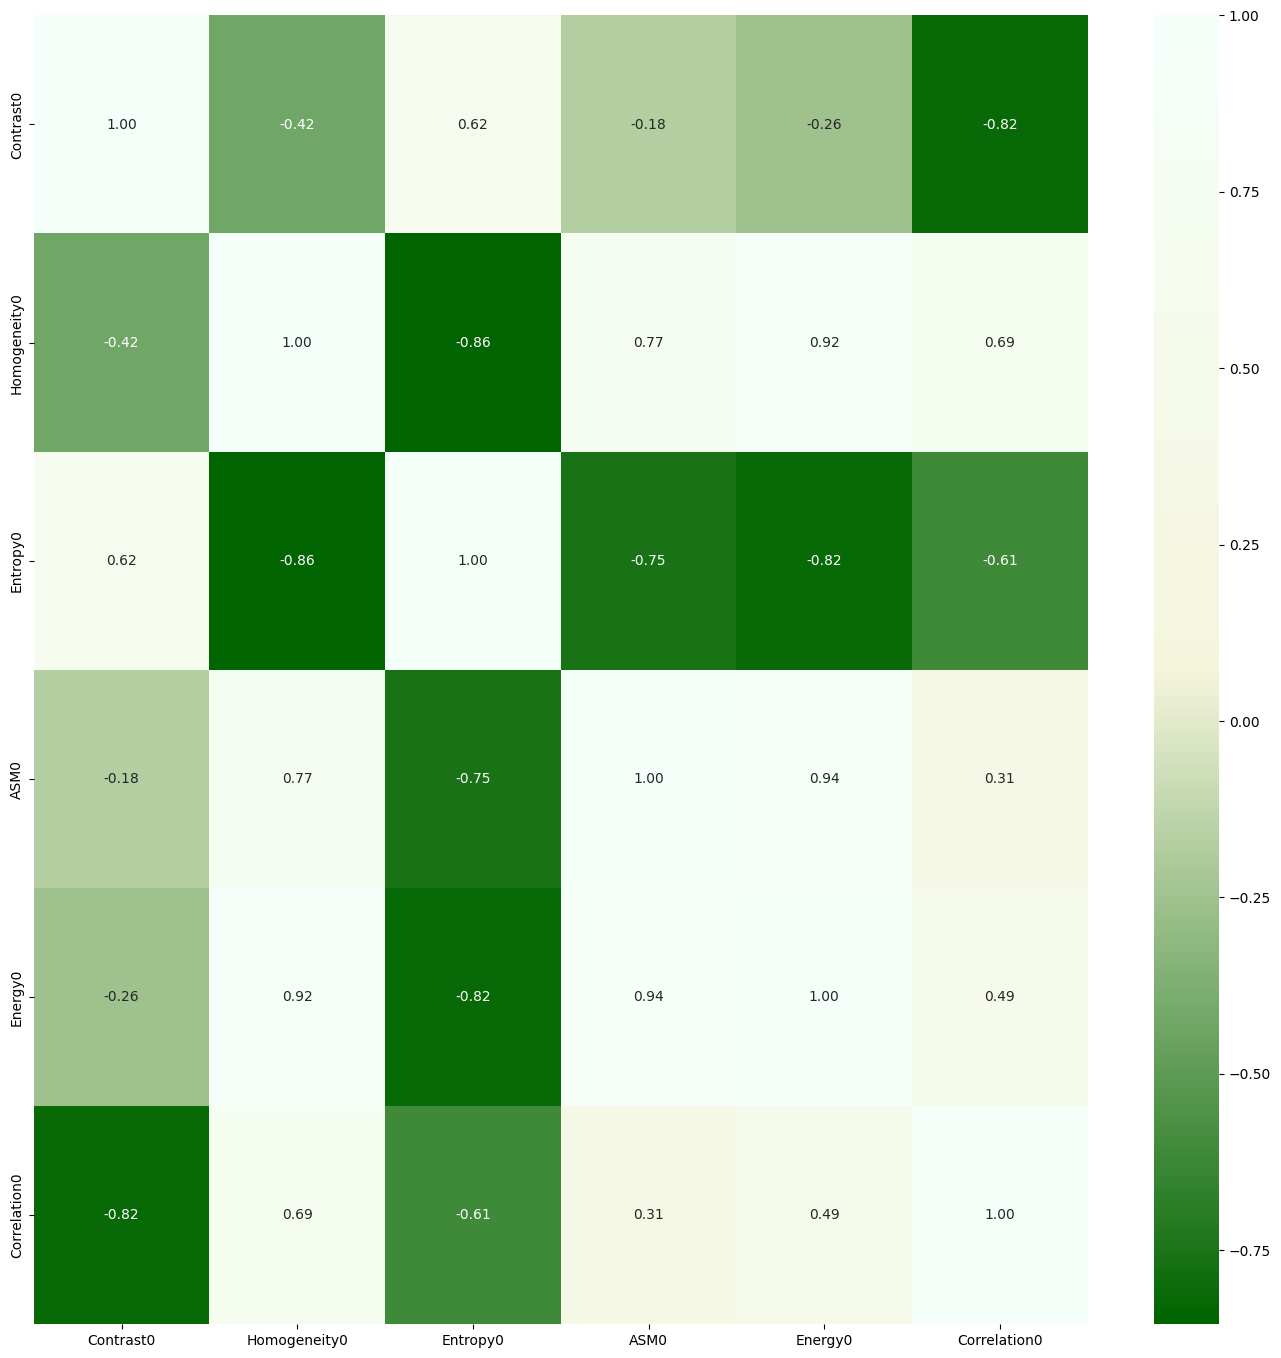

In [98]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))

green_cmap = LinearSegmentedColormap.from_list("green_shade", ["darkgreen", "beige", "mintcream"], N=256)
sns.heatmap(x_new.corr(), annot=True, cmap=green_cmap, fmt=".2f")

Kode ini digunakan untuk membagi dataset menjadi dua bagian, yaitu data untuk pelatihan (training) dan data untuk pengujian (testing). Parameter `test_size` menentukan proporsi data yang akan digunakan sebagai data testing. Misalnya, `test_size=0.3` berarti 30% data akan digunakan untuk testing, sedangkan sisanya 70% digunakan untuk training. Jika ingin menggunakan 20% data untuk testing, maka cukup ubah `test_size` menjadi 0.2. Fungsi `train_test_split` dari scikit-learn juga diberi parameter `random_state=42` agar pembagian data bersifat reproducible atau dapat diulang dengan hasil yang sama. Setelah pembagian, kode mencetak ukuran data training dan testing untuk memastikan proporsi pembagian sudah benar.

In [99]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)

(140, 6)
(60, 6)


Kode tersebut melakukan proses normalisasi data dengan metode standardisasi menggunakan mean dan standar deviasi dari data pelatihan (training set). Pertama, rata-rata (mean) dan penyebaran data (standar deviasi) dihitung berdasarkan fitur-fitur pada data pelatihan. Selanjutnya, kedua dataset, baik data pelatihan maupun data pengujian, dinormalisasi dengan mengurangi nilai mean dan membagi dengan standar deviasi tersebut. Langkah ini bertujuan agar semua fitur memiliki skala yang seragam, dengan rata-rata nol dan standar deviasi satu, sehingga model machine learning dapat belajar secara lebih efektif dan menghasilkan performa yang lebih baik. Penting untuk menggunakan statistik dari data pelatihan saja agar tidak terjadi kebocoran informasi dari data pengujian yang dapat menyebabkan hasil evaluasi model menjadi bias.


In [100]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode ini mendefinisikan sebuah fungsi bernama `generateClassificationReport` yang digunakan untuk mengevaluasi performa model klasifikasi. Fungsi ini menerima dua parameter, yaitu label asli (`y_true`) dan label hasil prediksi model (`y_pred`). Di dalam fungsi, ditampilkan laporan klasifikasi lengkap yang mencakup metrik seperti precision, recall, dan f1-score untuk setiap kelas, serta confusion matrix yang menunjukkan jumlah prediksi benar dan salah antar kelas. Selain itu, fungsi juga menghitung dan menampilkan akurasi keseluruhan dari prediksi model. Selanjutnya, kode mendefinisikan tiga algoritma klasifikasi yang akan digunakan untuk pelatihan dan pengujian data, yaitu Random Forest dengan dua estimator pohon keputusan, Support Vector Machine dengan kernel radial basis function (RBF), dan K-Nearest Neighbors dengan jumlah tetangga sebanyak lima. Ketiga model ini disiapkan dengan parameter random state yang sama untuk menjaga konsistensi hasil saat pengulangan eksperimen.


In [101]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode ini melatih model Random Forest (`rf`) menggunakan data training (`X_train` dan `y_train`). Setelah proses pelatihan selesai, model digunakan untuk melakukan prediksi pada data training itu sendiri, kemudian hasil prediksi dibandingkan dengan label asli untuk mengevaluasi performa model pada data training. Evaluasi tersebut dilakukan dengan memanggil fungsi `generateClassificationReport` yang menampilkan metrik klasifikasi, confusion matrix, dan akurasi. Selanjutnya, model yang sudah dilatih juga diuji menggunakan data testing (`X_test`), dengan prediksi hasil testing dibandingkan dengan label asli `y_test`. Hasil evaluasi pada data testing ini juga dicetak untuk melihat seberapa baik model dapat mengeneralisasi pada data yang belum pernah dilihat sebelumnya. Output yang dihasilkan memberi gambaran perbedaan performa model antara data training dan testing, yang membantu dalam analisis apakah model mengalami overfitting atau underfitting.

In [102]:
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                precision    recall  f1-score   support

      basophil       0.97      1.00      0.99        69
seg_neutrophil       1.00      0.97      0.99        71

      accuracy                           0.99       140
     macro avg       0.99      0.99      0.99       140
  weighted avg       0.99      0.99      0.99       140

[[69  0]
 [ 2 69]]
Accuracy: 0.9857142857142858

------Testing Set------
                precision    recall  f1-score   support

      basophil       0.86      0.97      0.91        31
seg_neutrophil       0.96      0.83      0.89        29

      accuracy                           0.90        60
     macro avg       0.91      0.90      0.90        60
  weighted avg       0.91      0.90      0.90        60

[[30  1]
 [ 5 24]]
Accuracy: 0.9


Kode ini melatih model Support Vector Machine (SVM) menggunakan data training (`X_train` dan `y_train`). Setelah model selesai dilatih, model tersebut digunakan untuk melakukan prediksi pada data training dan hasilnya dievaluasi dengan membandingkan prediksi dengan label asli `y_train`. Evaluasi ini dilakukan dengan memanggil fungsi `generateClassificationReport` yang menampilkan laporan klasifikasi lengkap, confusion matrix, dan akurasi untuk data training. Selanjutnya, model diuji pada data testing (`X_test`) dan hasil prediksi dibandingkan dengan label asli `y_test` untuk menilai kemampuan generalisasi model pada data yang belum pernah dilihat sebelumnya. Output evaluasi pada data testing ini membantu melihat performa SVM secara menyeluruh pada kedua set data, baik training maupun testing.

In [103]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                precision    recall  f1-score   support

      basophil       0.95      1.00      0.97        69
seg_neutrophil       1.00      0.94      0.97        71

      accuracy                           0.97       140
     macro avg       0.97      0.97      0.97       140
  weighted avg       0.97      0.97      0.97       140

[[69  0]
 [ 4 67]]
Accuracy: 0.9714285714285714

------Testing Set------
                precision    recall  f1-score   support

      basophil       0.88      0.97      0.92        31
seg_neutrophil       0.96      0.86      0.91        29

      accuracy                           0.92        60
     macro avg       0.92      0.91      0.92        60
  weighted avg       0.92      0.92      0.92        60

[[30  1]
 [ 4 25]]
Accuracy: 0.9166666666666666


Kode ini digunakan untuk melatih model K-Nearest Neighbors (KNN) menggunakan data pelatihan (`X_train` dan `y_train`). Setelah proses pelatihan selesai, model kemudian digunakan untuk memprediksi kelas pada data pelatihan itu sendiri, dan hasil prediksi tersebut dievaluasi menggunakan fungsi `generateClassificationReport` yang menampilkan laporan klasifikasi lengkap, matriks kebingungan (confusion matrix), serta nilai akurasi. Selanjutnya, model diuji pada data pengujian (`X_test`) untuk menilai seberapa baik performa model pada data yang belum pernah dilihat sebelumnya. Evaluasi pada data pengujian ini juga menggunakan fungsi yang sama untuk memberikan gambaran lengkap tentang kemampuan generalisasi model KNN. Dengan cara ini, kita dapat membandingkan performa KNN antara data pelatihan dan pengujian secara jelas.


In [104]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                precision    recall  f1-score   support

      basophil       0.91      0.99      0.94        69
seg_neutrophil       0.98      0.90      0.94        71

      accuracy                           0.94       140
     macro avg       0.95      0.94      0.94       140
  weighted avg       0.95      0.94      0.94       140

[[68  1]
 [ 7 64]]
Accuracy: 0.9428571428571428

------Testing Set------
                precision    recall  f1-score   support

      basophil       0.86      0.97      0.91        31
seg_neutrophil       0.96      0.83      0.89        29

      accuracy                           0.90        60
     macro avg       0.91      0.90      0.90        60
  weighted avg       0.91      0.90      0.90        60

[[30  1]
 [ 5 24]]
Accuracy: 0.9


Kode ini digunakan untuk memvisualisasikan *confusion matrix* dari tiga model klasifikasi berbeda: Random Forest, SVM (Support Vector Machine), dan KNN (K-Nearest Neighbors). Fungsi `plot_confusion_matrix` menerima label sebenarnya (`y_true`) dan hasil prediksi model (`y_pred`), kemudian menghasilkan dan menampilkan *confusion matrix* dalam bentuk grafik visual menggunakan `ConfusionMatrixDisplay` dari scikit-learn. Warna grafik menggunakan kolormap gradasi hijau (`green_cmap`) agar tampilan lebih estetis dan mudah dibaca.

Setiap pemanggilan fungsi ditujukan untuk masing-masing model—Random Forest, SVM, dan KNN—sehingga pengguna dapat membandingkan performa ketiga model dalam mengklasifikasikan data uji. Matriks kebingungan ini memberikan informasi penting seperti jumlah prediksi benar dan salah untuk setiap kelas, yang berguna untuk mengevaluasi akurasi serta kesalahan klasifikasi secara lebih detail.

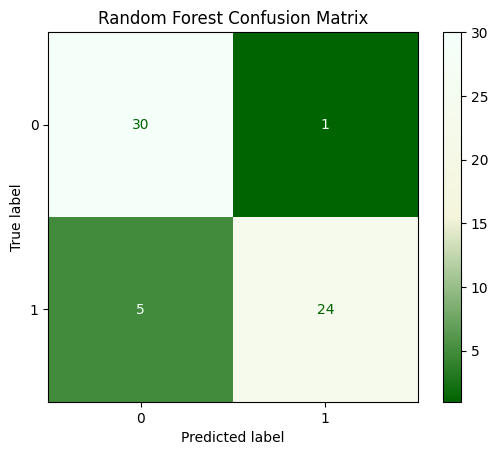

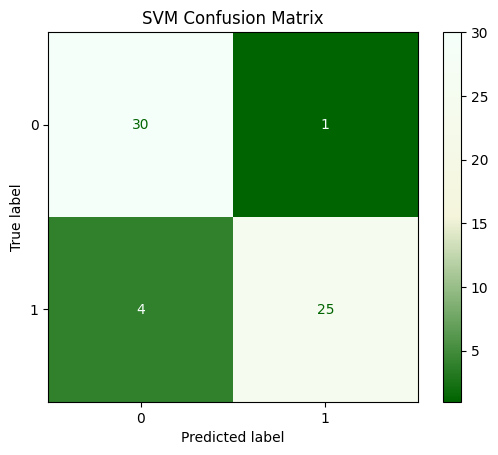

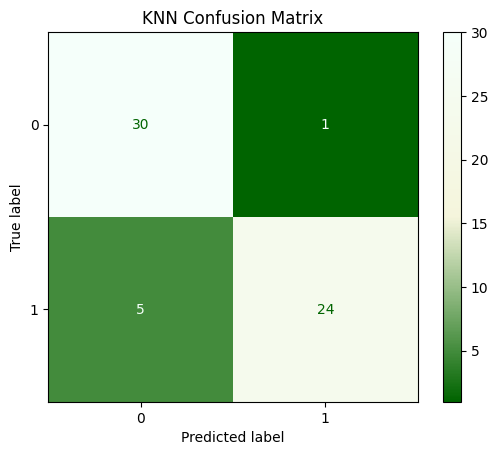

In [105]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=green_cmap)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")